# Projet Dispositif medicaux

Use the output of the following simulation:
- Folder: dosimetry/
- Macros: ex2.mac, ex3.mac

Helping ressources: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks

In [ ]:
!pip install ipympl
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from ipywidgets import interact
import os
from pathlib import Path

In order to be able to run the interactive plot, you must install ipympl as indicated here: https://github.com/matplotlib/ipympl
This is activated by the previous `%matplotlib widget` line.

In [ ]:
# The following command display the current working directory (where jupyter has been launched)
cwd = os.getcwd()
print('The Current Working Directory (CWD) is: \n', cwd)
folder = Path()
if (not folder.is_dir()):
    print('ERROR: {} is not a folder.'.format(folder))

The Current Working Directory (CWD) is: 
 /content


**1.1. Dimensions de lans ITK-SNAP, afficher le scanner (CT) patient de l’exemple patient-2mm.mhd. Indiquer les d'image et sont range.**

In [ ]:
# Read a sitk image
filename = os.path.join(folder,'./patient-2mm.mhd')
img_ct = sitk.ReadImage(filename)
print('Image size: ', img_ct.GetSize())
print('Image spacing: ', img_ct.GetSpacing())
print('Image origin: ', img_ct.GetOrigin())

Image size:  (126, 126, 111)
Image spacing:  (2.0, 2.0, 2.0)
Image origin:  (0.0, 0.0, 0.0)


La taille de l’image est  126 x 126 x 111 dont


*   La longueur en X est 126
*   La longueur en Y est 126
*   La longueur en Z est 111

Le range de l’image est de -1050 à 3001 (valeurs limites dans le fichier patient-HU2mat.txt

**1.2. Quelles sont les unités ? À quoi sont-elles reliées ?**

L'échelle de Hounsfield, nommée ainsi d'après Sir Godfrey Newbold Hounsfield, est une échelle quantitative décrivant la radiodensité. L'échelle des unités de Hounsfield (UH) est une transformation linéaire de la mesure du coefficient d'absorption original dans laquelle la densité de l'eau distillée, aux conditions normales de température et de pression (CNTP), est définie à zéro unité Hounsfield (UH), tandis que la densité de l'air aux CNTP est définie à −1 000 UH.


In [ ]:
# Convert sitk image to a numpy array
arr_ct = sitk.GetArrayFromImage(img_ct)
print('Array size: ', arr_ct.shape, ' <--- be careful to the dimension order!)')

Array size:  (111, 126, 126)  <--- be careful to the dimension order!)


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

interactive(children=(IntSlider(value=63, description='sx', max=126), IntSlider(value=63, description='sy', ma…

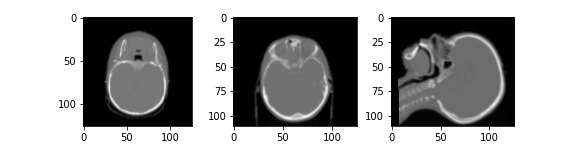

In [ ]:
# Visualisation d'images du patient à traiter
fig, ax = plt.subplots(1,3, figsize=(8, 2))
def show_ct(sx,sy,sz):
    ax[0].imshow(arr_ct[sz,:,:], cmap=plt.cm.gray)
    ax[1].imshow(arr_ct[:,sx,:], cmap=plt.cm.gray)
    ax[2].imshow(arr_ct[:,:,sy], cmap=plt.cm.gray)
    
interact(show_ct, sx=(0,img_ct.GetSize()[0]), sy=(0,img_ct.GetSize()[1]), sz=(0,img_ct.GetSize()[2]));

**2.1. Définition des matériaux. Indiquer l’utilité individuelle des fichiers : patient-HU2mat.txt, patient-HUmaterials.db, GateMaterials.db**

En examinant chacun des fichiers, les informations qu'ils fournissent peuvent être déduites comme suit :

***“GateMaterials.db” :*** 
```
/gate/geometry/setMaterialDatabase GateMaterials.db
```

Ce fichier contient toutes les informations nécessaires à Gate pour attribuer les propriétés nucléaires à partir des jeux de données de Geant4. Cette base de données des matériaux contient deux structures Geant4 appelées éléments et matériaux qui sont utilisées pour définir les propriétés physiques des atomes, des molécules et des composés.

***“patient-HU2mat.txt”, “patient-HUmaterials.db” :***
```
/gate/HounsfieldMaterialGenerator/SetOutputMaterialDatabaseFilename data/patient-HUmaterials.db
```
```
/gate/HounsfieldMaterialGenerator/SetOutputHUMaterialFilename       data/patient-HU2mat.txt
```

Ces deux commands du HounsfieldMaterialGenerator donnent deux fichiers qui permet générer une correspondance entre HU (valeurs de voxel) et matériau:

*   Le fichier “patient-HUmaterials.db” définit les caractéristiques physiques de chaque material
*   Le fichier “patient-HU2mat” définit les rangs des unités Hounsfield qui correspondent à chaque matériel.


```
/gate/geometry/setMaterialDatabase data/patient-HUmaterials.db
```
Ce macro ajoute plus de matériaux (et leurs caractéristiques) à la base de donnés du Gate.

```
/gate/patient/geometry/setHUToMaterialFile data/patient-HU2mat.txt
```
Le fichier “patient-HU2mat.txt” définit la transformation d'unités Hounsfield à matériaux que Gate doit faire pour représenter physiquement l’image CT-scanner du patient.


**2.2. Tracer la courbe fournie par Schneider2000DensitiesTable.txt . Commenter**

"Schneider2000DensitiesTable.txt" : fichier texte de calibration pour indiquer la relation entre HU et la densité de masse (g/cm3). Elle est normalement donnée par l'étalonnage de votre scanner. 

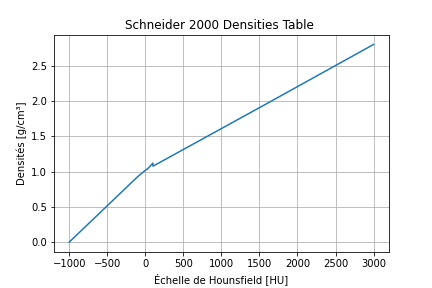

In [ ]:
hus = []
densities = []
with open('./Schneider2000DensitiesTable.txt') as f:
    data = f.readlines()[3:]
    for line in data:
        hu, density = line.split()
        hus.append(int(hu))
        densities.append(float(density))

fig4, ax4 = plt.subplots()
ax4.plot(hus, densities)
ax4.set_title('Schneider 2000 Densities Table ')
ax4.set_xlabel('Échelle de Hounsfield [HU]')
ax4.set_ylabel('Densités [g/cm³]')
ax4.grid()
plt.show()

Commentaires : 
* La densité augmente plus lentement à partir du HU=0
* Dans la table HU=101 a un densité inférieur à celle du HU=100


**3. Explication des termes macro GATE suivantes :**

```
/gate/patient/geometry/setImage data/patient-2mm.mhd
```

Ce macro définit l’image du patient à simuler

```
/gate/geometry/setMaterialDatabase data/patient-HUmaterials.db
```

Ce macro ajoute plus de matériaux (et leurs caractéristiques) à la base de donnés du Gate

```
/gate/patient/geometry/setHUToMaterialFile data/patient-HU2mat.txt
```

Ce macro définit le fichier à utiliser pour transformer les unités Hounsfield à matériaux physiques

```
/gate/physics/addPhysicsList QGSP_BERT_EMV
```

Cette macro définit le constructeur du physique des interactions des particules qui auront lieu pendant la simulation.
* QGSP : Quark gluon string model (>~20GeV) 
* BERT : Bertini Cascade Model (<~10 GeV)
* EMV : Variation of Standard EM package 
* QGSP_BERT_EMV : C’est constructeur de listes en physique hadronique

```
/gate/actor/addActor DoseActor dose3d
```

Ce macro ajoute un acteur du type “DoseActor” à la simulation

Les acteurs sont des outils qui permettent d'interagir avec la simulation. Ils peuvent collecter des informations pendant la simulation, comme le dépôt d'énergie, le nombre de particules créées dans un volume donné, etc. Ils peuvent également modifier le comportement de la simulation. 

Le “DoseActor” construit des images 3D de l'énergie déposée (edep), de la dose déposée et du nombre de coups dans un volume de boîte donné. Il prend en compte le poids des particules.

**4. Afficher maintenant l’IRM, le CT et la masque de segmentation Gross Target Volume (GTV) du patient du CHRU de Brest BrainMets-CHRU-10.**

Grâce à ITKSNAP, le masque de segmentation de l'IRM, le scanner et le volume cible brut (GTV) du patient BrainMets-CHRU-10 du CHRU de Brest sont affichés ensemble, ce qui permet de visualiser la tumeur du patient en dessous :

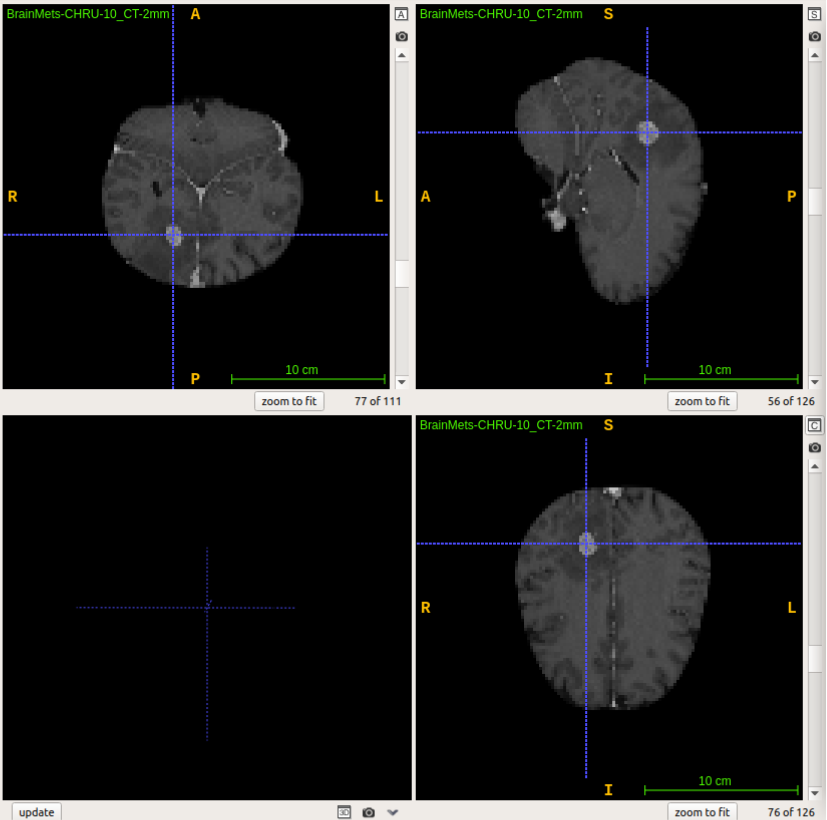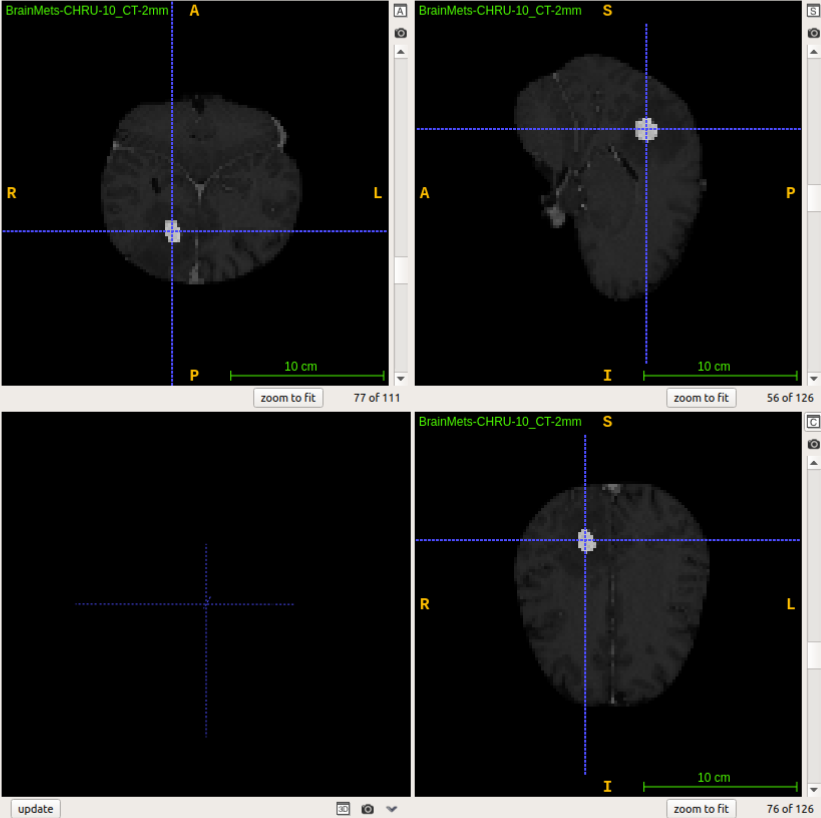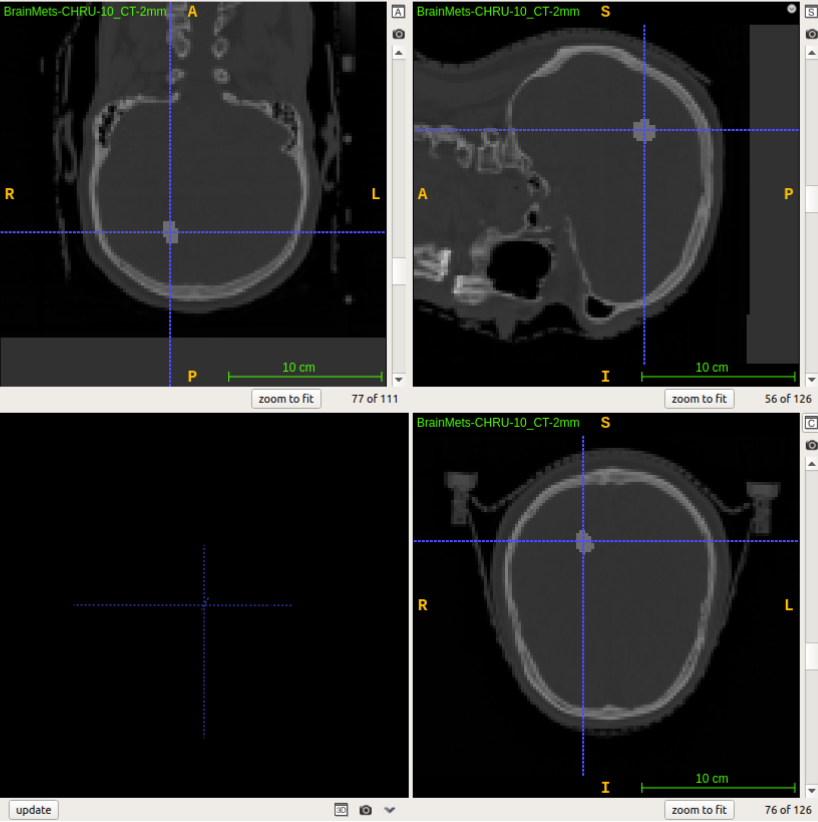

**5. Quelles sont les coordonnées du centre de la tumeur ?**

À l'aide de l'ITKSNAP, vous trouverez les coordonnées du centre de la tumeur à: 

      (x,y,z) = (56,76,77)


**6. Adapter une nouvelle macro dérivée de ex3.mac pour traiter ce patient.**

On a change le patient en ex3.mac pour BrainMets-CHRU-10_CT-2mm_clip.mhd qui est le patient a traiter


**7.Superposer le dose déposée 3d-pat-proton avec son orientation initiale (sans changement du faisceau).**

L'orientation initiale du faisceau est visible ci-dessous:
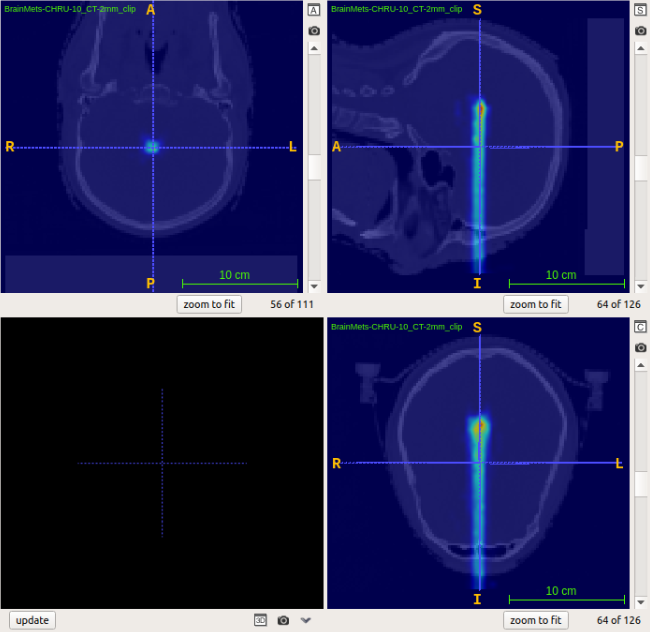

Nous pouvons constater que le faisceau de direction (x,y,z) = (0,0,1) passe par le milieu de la boîte sur laquelle nous travaillons. Nous devons changer sa direction afin d'arriver à la position désirée.

**8) Quel est l’effet d’une augmentation d'énergie du faisceau?**

On change l'énergie de 140 MeV a 170 MeV dans le mac ex3.mac, que nous avons nommés d'après tous les membres du groupe. Le résultat observé est que si on augmente l'énergie du faisceau il aura une augmentation de la pénétration.

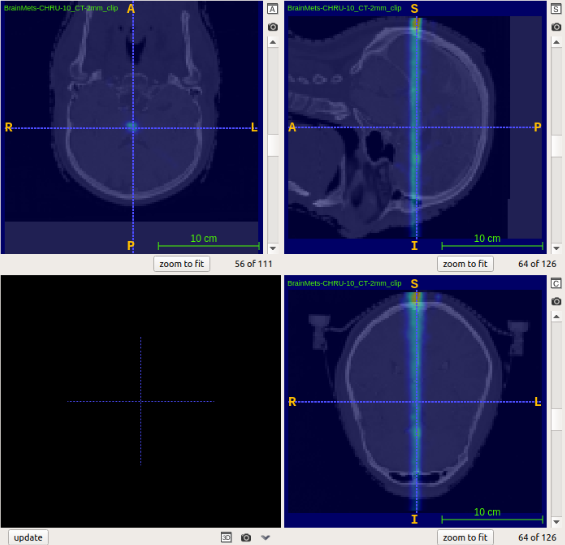

On peut observer qu'après avoir augmenté l'énergie du faisceau, celui-ci traverse le crâne du patient, ne remplissant pas l'objectif d'atteindre un point précis du cerveau.


**9) Adapter l’orientation du faisceau pour avoir un pic de Bragg centre autour de la tumeur de ce patient. Produire quelques résultats visuels.**

On doit changer la direction du faisceau pour cibler le tumeur. Dans ce cas, on a changé les coordonées du faisceau pour (x,y,z) = (-8,12,158).  On a obtenu ces coordonnées en tenant compte que le point (0,0,272)mm=(0,0,137)voxel représente le centre de la boîte de coordonnées (63,63,56) pour le faisceau. C'est a dire que pour le nouvelle origin, le point d'intérêt sera situé à (x-64,y-64,(z-56)+137). Après la simulation, on a trouve (par identification) que le tumeur se trouve à la position (56,75,77) dans le référentiel “boîte”. Donc la direction de faisceau doit etre (56-64,75-64,(77-56)+137)=(-8,12,158)

Finalement, on a augmenté l'énergie du faisceau de 140 MeV a 145 MeV, pour avoir une orientation totale du faisceau dans le tumeur.


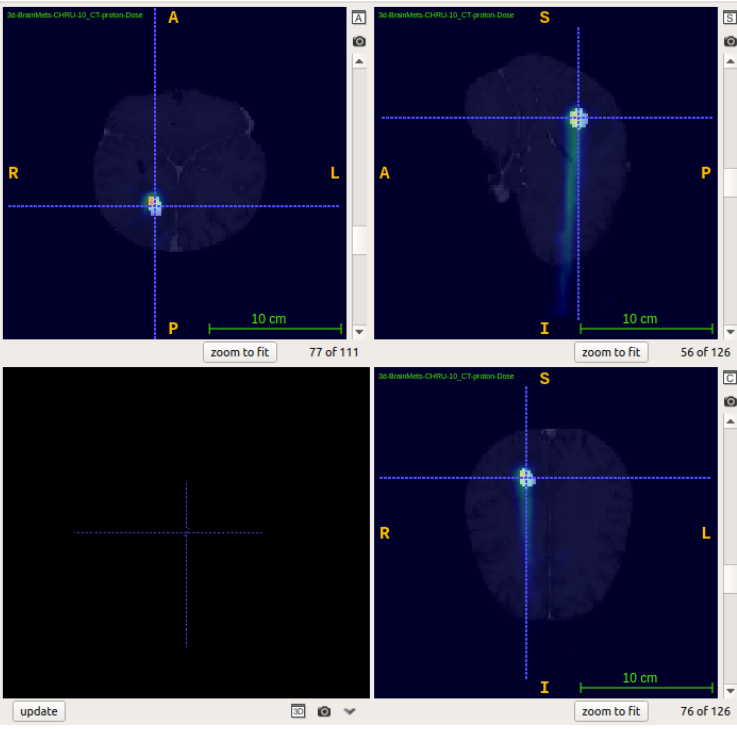

Après avoir modifié la macro et exécuté la simulation, avoir les résultats, L'IRM du patient est chargée, lue et convertie en un tableau de données pour afficher ultérieurement la size du array, ainsi que ses valeurs maximale et minimale.

In [ ]:
filename = os.path.join(folder, './3d-BrainMets-CHRU-10_CT-proton-Dose.mhd')    
img_dose = sitk.ReadImage(filename)
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

Image size =  (50, 50, 50)
Image min and max:  0.0 3.0103345e-07


In [ ]:
#Image filter
filter = sitk.RescaleIntensityImageFilter()
filter.SetOutputMaximum(1.0)
filter.SetOutputMinimum(0.0)
img_dose = filter.Execute(img_dose)

In [ ]:
#Size image and minimum and maximum values after image filter
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

Image size =  (50, 50, 50)
Image min and max:  0.0 1.0


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

interactive(children=(IntSlider(value=24, description='nslice', max=49), Output()), _dom_classes=('widget-inte…

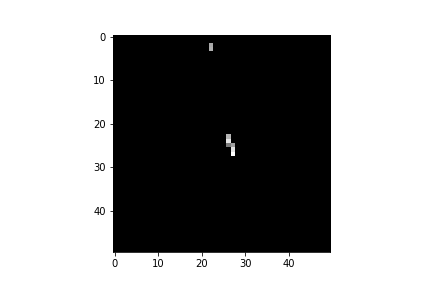

In [ ]:
# Tracer le faisceau
fig1, ax1 = plt.subplots()
def show_dose(nslice):
    im = ax1.imshow(arr_dose[:,nslice,:], cmap=plt.cm.gray)
interact(show_dose, nslice=(0,len(arr_dose)-1));

In [ ]:
img_resampled_dose = sitk.Resample(img_dose, img_ct, sitk.Transform(), sitk.sitkLinear, 0)

In [ ]:
arr_resampled_dose = sitk.GetArrayFromImage(img_resampled_dose)
print('Image size = ', arr_resampled_dose.shape)
print('Image min and max: ',  np.amin(arr_resampled_dose), np.amax(arr_resampled_dose))

Image size =  (111, 126, 126)
Image min and max:  0.0 0.8810486


interactive(children=(IntSlider(value=58, description='nslice', max=111), FloatSlider(value=0.7, description='…

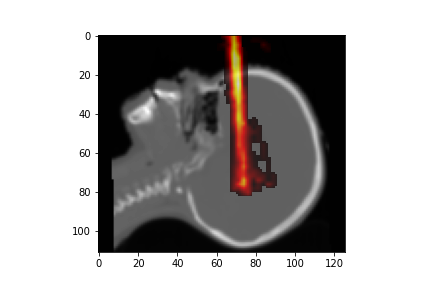

In [ ]:
#Tracer le faisceau dans le tete du pacient
fig2, ax2 = plt.subplots()
def show_fusion(nslice=58, opacity=0.7):
    ax2.imshow(arr_ct[:,:,nslice], cmap=plt.cm.gray)
    a = arr_resampled_dose[:,:,nslice]
    b = np.ma.masked_where(a <= 0.001, a)
    ax2.imshow(b, alpha=opacity, cmap=plt.cm.hot)
    
interact(show_fusion, nslice=(0,len(arr_ct)), opacity=(0,1,0.1));

**10. 1D plot from 3D proton dose**

In [ ]:
filename_edep = os.path.join(str(folder), './3d-BrainMets-CHRU-10_CT-proton-Edep.mhd')
img_edep = sitk.ReadImage(filename_edep)
arr_edep = sitk.GetArrayFromImage(img_edep)

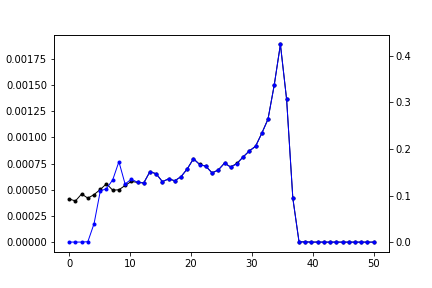

In [ ]:
# Declare a single figure (one row, one column)
fig3, ax3 = plt.subplots()
moy_dose=np.zeros(arr_dose.shape[0])
moy_edep=np.zeros(arr_edep.shape[0])
for i in range(arr_dose.shape[0]):
    subarr_dose=arr_dose[i,:,:]
    moy_dose[i]=np.mean(subarr_dose)
    subarr_edep=arr_edep[i,:,:]
    moy_edep[i]=np.mean(subarr_edep)

# X values from 0 to n
# n is the number of slices
n = arr_dose.shape[0]
x = np.linspace(0, n, n)

c1 = ax3.plot(x, moy_dose, 'k.-', label='deposited dose', linewidth=1)
ax32 = ax3.twinx()
c2 = ax32.plot(x, moy_edep, 'b.-', label='deposited energy', linewidth=1)